The S414 is a slotted, natural-laminar-flow airfoil. It is designed to have a laminar bucket between CL=.1 and CL=.65, but also have the ability to achieve high angles of attack and lift coefficients[1]. Below, the windtunnel results and the CFD results from the literature are compared to the results predicted by viiflow.
For OVERFLOW, the transition model in [2] was used.

All CFD methods use a transition model, and all are able to predict the laminar bucket and show good agreement with the measurements. Viiflow does predict a stronger increase in drag below the laminar bucket compared to the other methods and the windtunnel results. All methods overpredict maximum lift, with viiflow and MSES closely agreeing on the lift slope, which is not surprising given their similar boundary layer formulation.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import viiflow as vf
import viiflowtools.vf_tools as vft
import viiflowtools.vf_plots as vfp
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

interactive_plot = False
# For interactive plots uncomment the following
#%matplotlib notebook
#matplotlib.rcParams['figure.figsize'] = [9, 6] # Make plots bigger than default
#interactive_plot = True
#lines = None
#fig, ax = plt.subplots(1,1)

AL: -5.000000 CL: -0.129763 CD0: 0.009314 CD1: 0.003565
AL: -4.800000 CL: -0.103000 CD0: 0.009137 CD1: 0.003570
AL: -4.600000 CL: -0.075848 CD0: 0.009009 CD1: 0.003569
AL: -4.400000 CL: -0.046414 CD0: 0.008703 CD1: 0.003566
AL: -4.200000 CL: -0.020376 CD0: 0.008515 CD1: 0.003566
AL: -4.000000 CL: 0.002223 CD0: 0.008328 CD1: 0.003575
AL: -3.800000 CL: 0.025960 CD0: 0.006971 CD1: 0.003585
AL: -3.600000 CL: 0.046962 CD0: 0.004215 CD1: 0.003263
AL: -3.400000 CL: 0.067287 CD0: 0.004187 CD1: 0.003266
AL: -3.200000 CL: 0.101845 CD0: 0.004170 CD1: 0.003392
AL: -3.000000 CL: 0.130618 CD0: 0.004130 CD1: 0.003481
AL: -2.800000 CL: 0.155059 CD0: 0.004093 CD1: 0.003536
AL: -2.600000 CL: 0.176282 CD0: 0.004100 CD1: 0.003536
AL: -2.400000 CL: 0.198112 CD0: 0.004097 CD1: 0.003547
AL: -2.200000 CL: 0.219512 CD0: 0.004096 CD1: 0.003554
AL: -2.000000 CL: 0.241636 CD0: 0.004096 CD1: 0.003560
AL: -1.800000 CL: 0.264085 CD0: 0.004100 CD1: 0.003581
AL: -1.600000 CL: 0.286164 CD0: 0.004107 CD1: 0.003580
AL: -

AL: 15.500000 CL: 2.039931 CD0: 0.037809 CD1: 0.003396
AL: 16.000000 CL: 2.040497 CD0: 0.043244 CD1: 0.003277
AL: 16.500000 CL: 2.052243 CD0: 0.046328 CD1: 0.003209
AL: 17.000000 CL: 2.029341 CD0: 0.051134 CD1: 0.003106
AL: 17.500000 CL: 1.970009 CD0: 0.058869 CD1: 0.002938


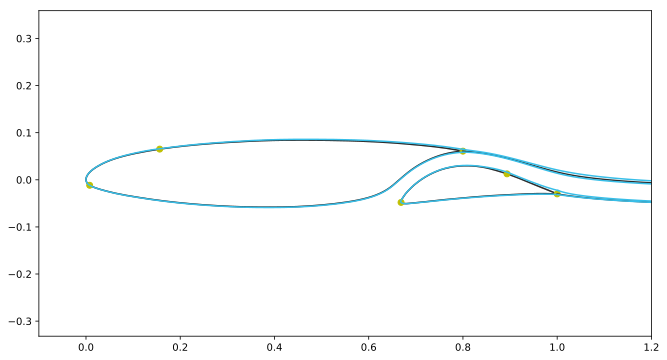

In [2]:
# Read airfoil data
BASE = vft.repanel_spline(vft.read_selig("S414Main.dat"),160)
BASE = BASE[:,::-1] # THey are from bottom to top in data file
SLOT = vft.repanel_spline(vft.read_selig("S414Aft.dat"),160)
SLOT = SLOT[:,::-1]

# More refined in laminar bucket
AOARANGE = np.r_[np.arange(-5,5,0.2),np.arange(5,18.5,0.5)]

# Scale to c=1
SCALE = np.max(SLOT[0,:])
BASE = BASE/SCALE;
SLOT = SLOT/SCALE;

# Setup
RE = 1.0e6
ncrit = 11.2
Mach = 0.1
AOA0 = AOARANGE[0]
s = vf.setup(Re=RE,Ma=Mach,ncrit=ncrit,alpha=AOA0)
s.iterate_wakes = False
s.itermax = 10
s.silent = True

# Use XFOIL Defaults
s.LocusA = 6.70
s.LocusB = 0.75


# Set-up and initialize based on inviscid panel solution
(p,bl,x) = vf.init([BASE,SLOT],s)

# result array
alv = []
clv = []
cdv = []

lines = None # For plot function
for alpha in AOARANGE:
    s.alpha = alpha
    res = None
    grad = None
    for k in range(int(100/s.itermax)): # Make effectively 100 iterations, but show some in between
        [x,flag,res,grad,_] = vf.iter(x,bl,p,s,res,grad)
        nres=np.sqrt(np.dot(res.T,res))
        
        # Plot geometry and update interactively
        if interactive_plot:
            lines = vfp.plot_geometry(ax,p,bl,lines)
            title = "AOA %f RES %f"%(alpha,nres)
            ax.set_title(title)
            fig.canvas.draw()
        elif alpha==5:
            matplotlib.rcParams['figure.figsize'] = [11, 6] # Make plots bigger than default
            fig, ax = plt.subplots(1,1)
            lines = vfp.plot_geometry(ax,p,bl,lines)

        # Decide whether to stop iterating
        if nres<2e-3:
            alv.append(alpha)
            clv.append(p.CL)
            cdv.append(bl[0].CD+bl[1].CD)
            print('AL: %f CL: %f CD0: %f CD1: %f' % (alpha,clv[-1],bl[0].CD,bl[1].CD) ) 
            break


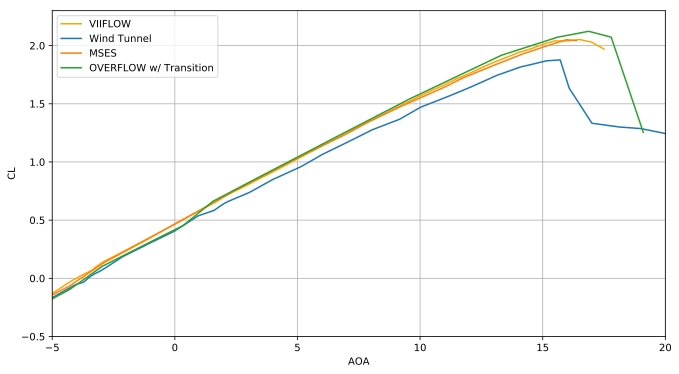

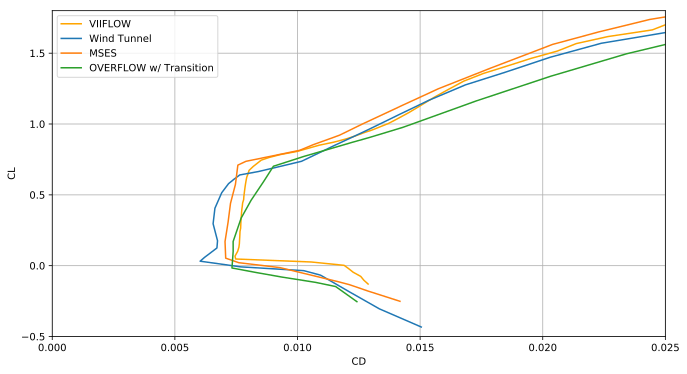

In [3]:
# Load airfoil measurement data
PolarMaughmerWT = np.genfromtxt("MaughmerPolar.csv",skip_header=2,delimiter=",",usecols=[0,1])
PolarMaughmerMSES = np.genfromtxt("MaughmerPolar.csv",skip_header=2,delimiter=",",usecols=[2,3])
PolarMaughmerOVERFLOW = np.genfromtxt("MaughmerPolar.csv",skip_header=2,delimiter=",",usecols=[4,5])
CLMaughmerWT = np.genfromtxt("MaughmerCL.csv",skip_header=2,delimiter=",",usecols=[0,1])
CLMaughmerMSES = np.genfromtxt("MaughmerCL.csv",skip_header=2,delimiter=",",usecols=[2,3])
CLMaughmerOVERFLOW = np.genfromtxt("MaughmerCL.csv",skip_header=2,delimiter=",",usecols=[4,5])

# Make a new plot with the results
fig,ax = plt.subplots(1,1)
ax.plot(alv,clv,color="orange")
ax.plot(CLMaughmerWT.T[0],CLMaughmerWT.T[1])
ax.plot(CLMaughmerMSES.T[0],CLMaughmerMSES.T[1])
ax.plot(CLMaughmerOVERFLOW.T[0],CLMaughmerOVERFLOW.T[1])


ax.set_xlabel('AOA')
ax.set_ylabel('CL')
ax.legend(['VIIFLOW','Wind Tunnel','MSES','OVERFLOW w/ Transition'])
ax.grid(1)
ax.set_xlim([-5,20])
ax.set_ylim([-0.5,2.3])

fig,ax = plt.subplots(1,1)
ax.plot(cdv,clv,color="orange")
ax.plot(PolarMaughmerWT.T[0]/1000,PolarMaughmerWT.T[1])
ax.plot(PolarMaughmerMSES.T[0]/1000,PolarMaughmerMSES.T[1])
ax.plot(PolarMaughmerOVERFLOW.T[0]/1000,PolarMaughmerOVERFLOW.T[1])

ax.set_xlabel('CD')
ax.set_ylabel('CL');
ax.legend(['VIIFLOW','Wind Tunnel','MSES','OVERFLOW w/ Transition'])
ax.set_xlim([0,0.025])
ax.set_ylim([-0.5,1.8])
ax.grid(1)

[1] Mark D. Maughmer, James G. Coder, and Dan M. Somers, *Exploration of a Slotted, Natural-Laminar-Flow Airfoil Concept*, 2018 Applied Aerodynamics Conference. Atlanta, Georgia. 

[2] James G. Coder and Mark D. Maughmer, *Fluid Dynamics Compatible Transition Modeling Using an Amplification Factor Transport Equation*, AIAA Journal 2014 52:11, 2506-2512 